In [1]:
from econml.grf import CausalForest, CausalIVForest, RegressionForest
from econml.dml import CausalForestDML
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

/Users/brendatorres/miniforge3/envs/ml_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd

data_1 = pd.read_csv(
    "data_normalized_fr.csv"
)
data_1

y_1 = data_1["Q1_1"]
z_1 = data_1["Q1_1_treat"]

y_2 = data_1["Q1_2"]
z_2 = data_1["Q1_2_treat"]

y_3 = data_1["Q2_1"]
z_3 = data_1["Q2_1_treat"]

y_4 = data_1["Q2_2"]
z_4 = data_1["Q2_2_treat"]

data_1["policy_preferences"] = (0.20*data_1["climatedesobedience_1"]) + (0.20*data_1["carbontax1"]) + (0.20*data_1["cartax_w1"]) + (0.20*data_1["meattax_w1"]) + (0.20*data_1["housingtax_w1"])
data_1["longlistbeh_score"] = (0.1*data_1["longlistbeh_w1_1"]) + (0.1*data_1["longlistbeh_w1_2"]) + (0.1*data_1["longlistbeh_w1_3"]) + (0.1*data_1["longlistbeh_w1_4"]) + (0.1*data_1["longlistbeh_w1_5"]) + (0.1*data_1["longlistbeh_w1_6"]) + (0.1*data_1["longlistbeh_w1_7"]) + (0.1*data_1["longlistbeh_w1_8"]) + (0.1*data_1["longlistbeh_w1_9"]) + (0.1*data_1["longlistbeh_w1_10"])
data_1["world_issues"] = (0.125*data_1["worldissues_1"]) + (0.125*data_1["worldissues_2"]) + (0.125*data_1["worldissues_3"]) + (0.125*data_1["worldissues_4"]) + (0.125*data_1["worldissues_5"]) + (0.125*data_1["worldissues_6"]) + (0.125*data_1["worldissues_7"]) + (0.125*data_1["worldissues_8"])
data_1["trust_in_science"] = (0.33*data_1["trustscientists_1"]) + (0.33*data_1["trustscientists_2"]) + (0.33*data_1["trustscientists_3"])


the_chosen_one = ["openness", "conscientiousness", "extraversion", "agreeableness", "neuroticism", 
                "world_issues", "trust_in_science", "policy_preferences", "Public_SelfConsciousness",
                "longlistbeh_score", "persconcern", "perspriority_3"]

x_cov = data_1[the_chosen_one]

In [27]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split

# yo necesito teoria para explicar pq este split puede ser 20/80 o 30/70
x_train_1, x_test_1, z_train_1, z_test_1, y_train_1, y_test_1 = train_test_split(x_cov, z_1, y_1, test_size=0.4, stratify=y_1, random_state= 2000)
x_train_2, x_test_2, z_train_2, z_test_2, y_train_2, y_test_2 = train_test_split(x_cov, z_2, y_2, test_size=0.4, stratify=y_2, random_state= 2000)
x_train_3, x_test_3, z_train_3, z_test_3, y_train_3, y_test_3 = train_test_split(x_cov, z_3, y_3, test_size=0.4, stratify=y_3, random_state= 2000)
x_train_4, x_test_4, z_train_4, z_test_4, y_train_4, y_test_4 = train_test_split(x_cov, z_4, y_4, test_size=0.4, stratify=y_4, random_state= 2000)


In [28]:
est = CausalForest(criterion='het', n_estimators=400, min_samples_leaf=5, max_depth=None,
                   min_var_fraction_leaf=None, min_var_leaf_on_val=True,
                   min_impurity_decrease = 0.0, max_samples=0.45, min_balancedness_tol=.45,
                   warm_start=False, inference=True, fit_intercept=True, subforest_size=4,
                   honest=True, verbose=0, n_jobs=-1, random_state=1235)

est.fit(x_train_1, z_train_1, y_train_1)



CausalForest(criterion='het', min_var_leaf_on_val=True, n_estimators=400,
             random_state=1235)

In [29]:
# Paso 1
ite_train = est.predict(x_train_1)

# Paso 2
cuartiles = np.percentile(ite_train, [25, 50, 75])
def asignar_cuartil(x):
    if x <= cuartiles[0]:
        return 1
    elif x <= cuartiles[1]:
        return 2
    elif x <= cuartiles[2]:
        return 3
    else:
        return 4

# Paso 3
ite_test = est.predict(x_test_1)
cuartiles_test = np.array([asignar_cuartil(val) for val in ite_test])

# Paso 4
ate_cuartil = []
ic_cuartil = []

for c in range(1, 5):
    idx = (cuartiles_test == c)
    ite_sub = ite_test[idx]
    
    ate_pred = ite_sub.mean()
    
    # Para el IC: si tienes std err (ejemplo)
    # Aquí solo un ejemplo: usando std dev / sqrt(n)
    std_err = ite_sub.std() / np.sqrt(len(ite_sub))
    
    ic_lower = ate_pred - 1.96 * std_err
    ic_upper = ate_pred + 1.96 * std_err
    
    ate_cuartil.append(ate_pred)
    ic_cuartil.append((ic_lower, ic_upper))

for i in range(4):
    print(f"Cuartil {i+1}: ATE={ate_cuartil[i]:.4f}, IC95%=[{ic_cuartil[i][0]:.4f}, {ic_cuartil[i][1]:.4f}]")


Cuartil 1: ATE=-0.1448, IC95%=[-0.1480, -0.1417]
Cuartil 2: ATE=-0.1102, IC95%=[-0.1117, -0.1087]
Cuartil 3: ATE=-0.0844, IC95%=[-0.0861, -0.0827]
Cuartil 4: ATE=-0.0440, IC95%=[-0.0483, -0.0397]


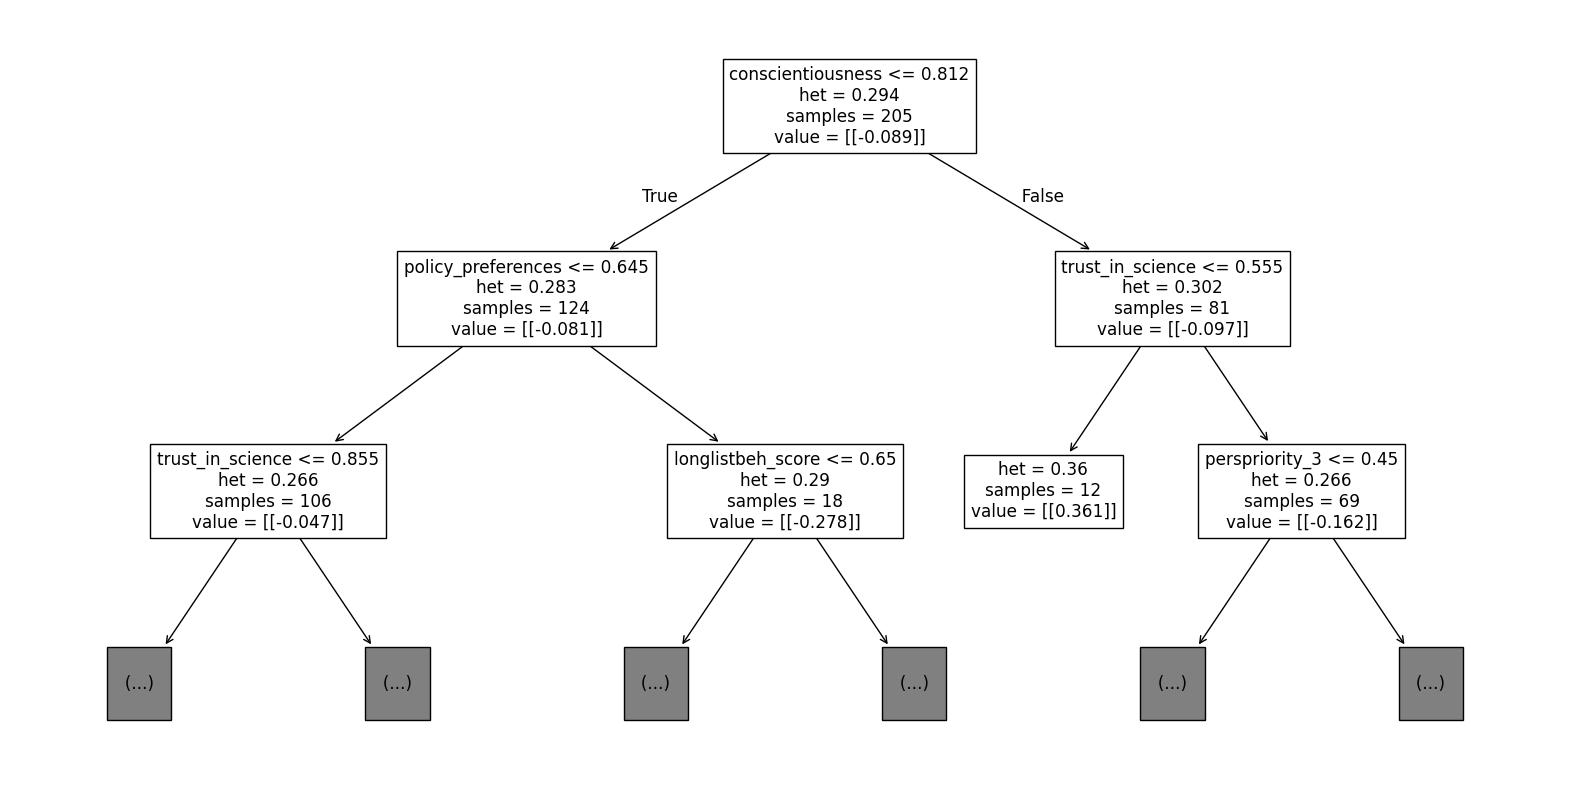

In [24]:
from sklearn.tree import DecisionTreeClassifier
from econml.grf._base_grftree import GRFTree
DecisionTreeClassifier.register(GRFTree)

plt.figure(figsize=(20, 10))
plot_tree(est[0], feature_names=the_chosen_one, impurity=True, max_depth=2) #grafica el arbol 0
plt.show()

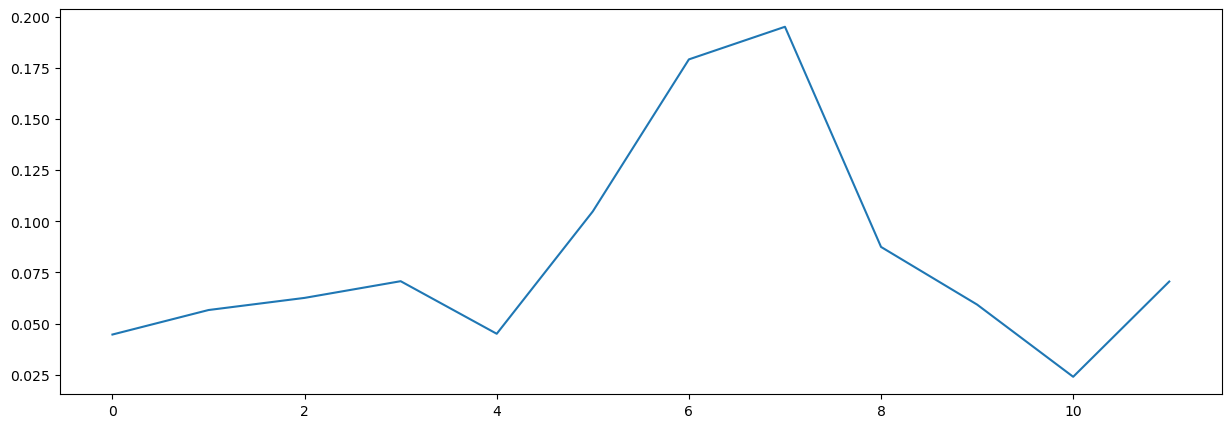

In [25]:
plt.figure(figsize=(15,5))
plt.plot(est.feature_importances(max_depth=4, depth_decay_exponent=2.0))
plt.show()

 98%|===================| 894/912 [00:25<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

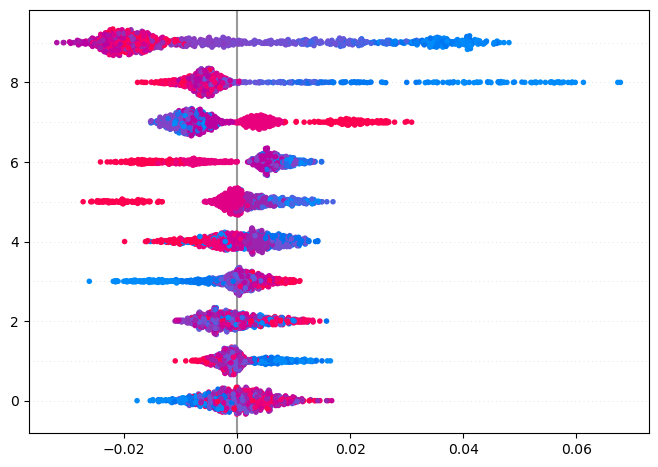

In [17]:
import shap
explainer = shap.Explainer(est, shap.maskers.Independent(x_cov, max_samples=100))
shap_values = explainer(x_cov, check_additivity=False)
shap.plots.beeswarm(shap_values)